<a href="https://colab.research.google.com/github/Omotoso526/farmer-tech-adoption-model/blob/main/Classical_ML_vs_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
import pandas as pd

df = pd.read_csv('/content/Farmers Adoption Data Plateau State - Sheet1 (1).csv')
df.head()

,AGE,SEX,EDUCATN STATUS,HH/SIZE,F/EXP,F/SIZE,EXT TRAINING,INCOME,ADOPTION STATUS
0,32,MALE,6,5,4,3,0,30000,1
1,32,FEMALE,12,4,5,4,1,31000,1
2,55,MALE,0,5,7,5,0,29000,1
3,56,FEMALE,12,6,8,3,0,26000,1
4,26,MALE,12,5,4,5,3,23000,0


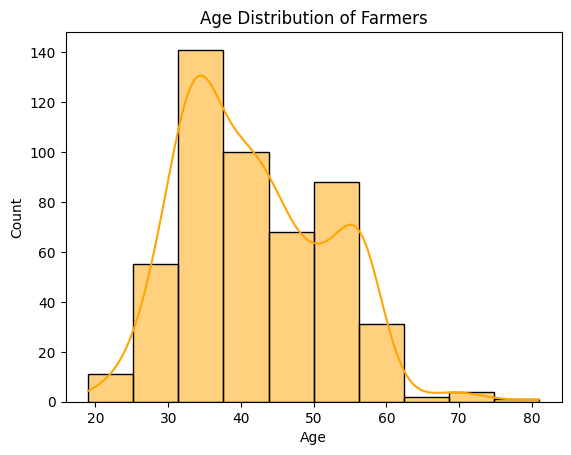

In [83]:
df_processed = df.copy()

import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_processed['AGE'], bins=10, kde=True, color='orange')
plt.title("Age Distribution of Farmers")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


In [84]:
df_processed['HAS_EDUCATION'] = df_processed['EDUCATN STATUS'].apply(lambda x: 1 if x > 0 else 0)


In [85]:
df_processed['SEX'] = df_processed['SEX'].map({'MALE': 1, 'FEMALE': 0})


In [86]:
# Check adoption rate by gender
df.groupby('SEX')['ADOPTION STATUS'].mean()


,ADOPTION STATUS
SEX,
FEMALE,0.534591
MALE,0.505848


In [87]:
df_processed.head()

,AGE,SEX,EDUCATN STATUS,HH/SIZE,F/EXP,F/SIZE,EXT TRAINING,INCOME,ADOPTION STATUS,HAS_EDUCATION
0,32,1,6,5,4,3,0,30000,1,1
1,32,0,12,4,5,4,1,31000,1,1
2,55,1,0,5,7,5,0,29000,1,0
3,56,0,12,6,8,3,0,26000,1,1
4,26,1,12,5,4,5,3,23000,0,1


/tmp/ipython-input-88-2951658855.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='EXT TRAINING', y='ADOPTION STATUS', data=df, palette='viridis')


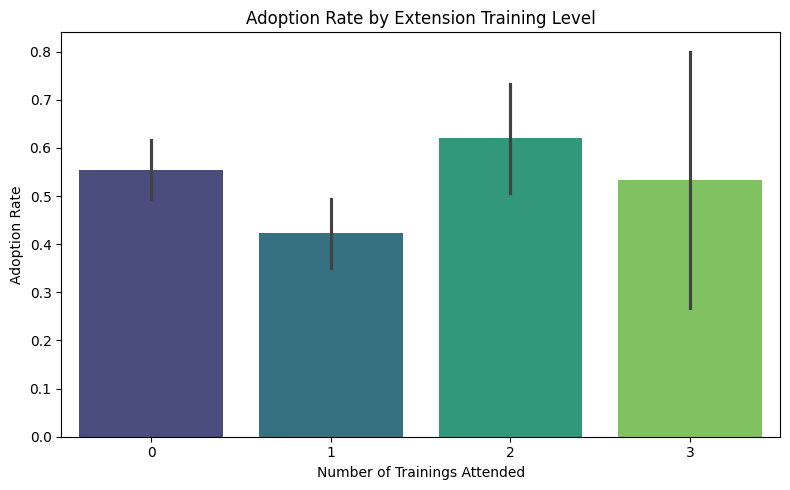

In [88]:
# 2. Bar Plot: Adoption Rate by Extension Training
plt.figure(figsize=(8, 5))
sns.barplot(x='EXT TRAINING', y='ADOPTION STATUS', data=df, palette='viridis')
plt.title('Adoption Rate by Extension Training Level')
plt.ylabel('Adoption Rate')
plt.xlabel('Number of Trainings Attended')
plt.tight_layout()
plt.show()

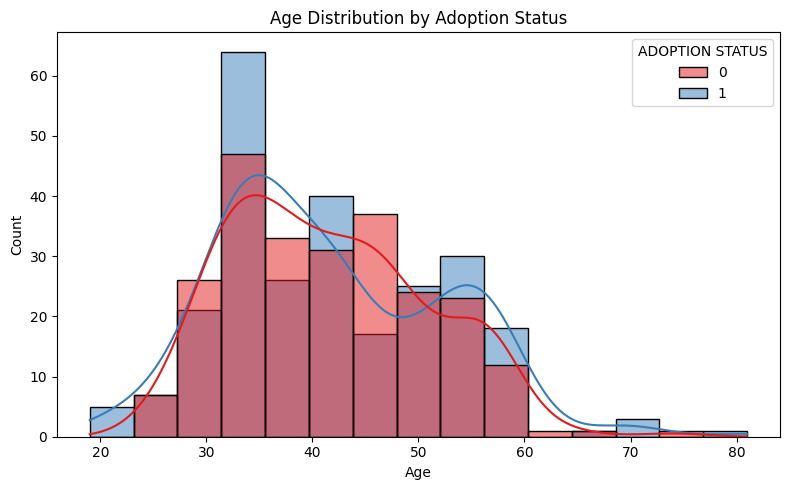

In [89]:
# 3. Histogram: Age Distribution by Adoption Status
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='AGE', hue='ADOPTION STATUS', bins=15, kde=True, palette='Set1')
plt.title('Age Distribution by Adoption Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

/tmp/ipython-input-90-3504794359.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed['INCOME'].fillna(df_processed['INCOME'].mean(), inplace=True)


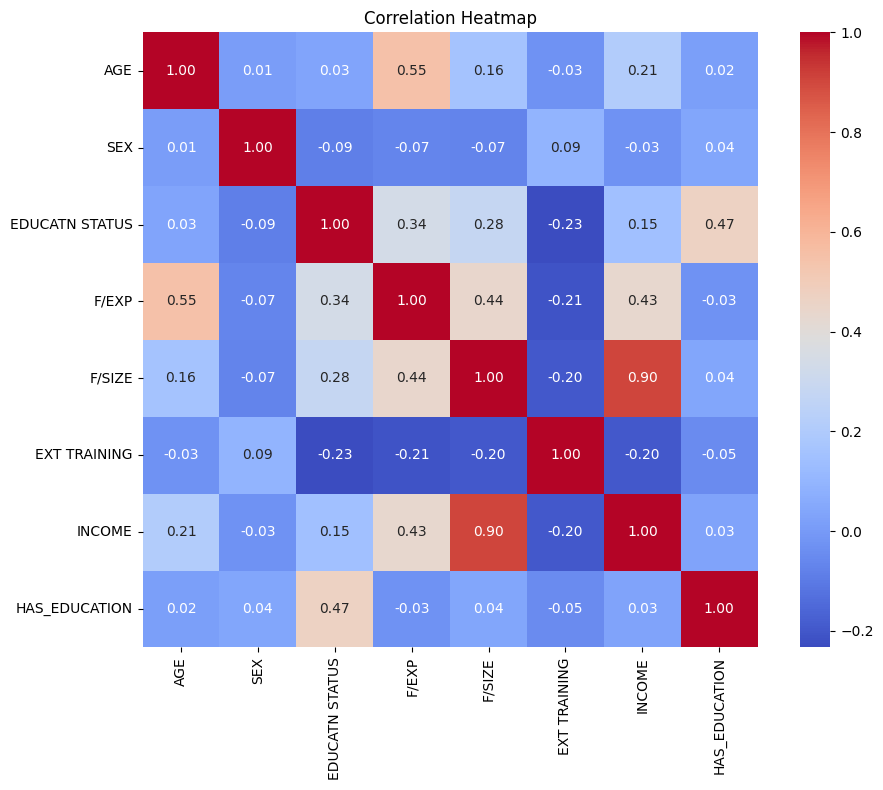

In [90]:
df_processed['INCOME'] = pd.to_numeric(df_processed['INCOME'], errors='coerce')
df_processed['INCOME'].fillna(df_processed['INCOME'].mean(), inplace=True)

plt.figure(figsize=(10, 8))
corr = df_processed.drop(columns=['ADOPTION STATUS']).corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

**Modeling**

In [134]:
from sklearn.model_selection import train_test_split
import pandas as pd
def set_random_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    np.random.seed(random_seed)
    random.seed(random_seed)

# Ensure HH/SIZE is numeric
df_processed['HH/SIZE'] = pd.to_numeric(df_processed['HH/SIZE'], errors='coerce')
df_processed['HH/SIZE'].fillna(df_processed['HH/SIZE'].mean(), inplace=True)

x = df_processed.drop(columns=['ADOPTION STATUS'])
y = df_processed['ADOPTION STATUS']

#split into train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

/tmp/ipython-input-134-1142616285.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed['HH/SIZE'].fillna(df_processed['HH/SIZE'].mean(), inplace=True)


In [135]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

pipeline = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])

param_dist = {
    'rf__n_estimators': [100, 300, 500],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__bootstrap': [True, False]
}

search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy'
)




In [136]:
best = search.fit(x_train, y_train)
print("Best params:", best.best_params_)
print("Best score:", best.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'rf__n_estimators': 300, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 2, 'rf__max_features': 'sqrt', 'rf__max_depth': 10, 'rf__bootstrap': True}
Best score: 0.7350000000000001


In [137]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = best.predict(x_test)


print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.73      0.83      0.78        48
           1       0.83      0.72      0.77        53

    accuracy                           0.77       101
   macro avg       0.78      0.78      0.77       101
weighted avg       0.78      0.77      0.77       101



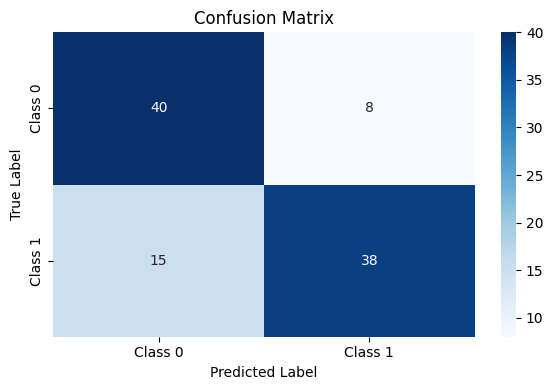

In [138]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Optional: Define class names
class_names = ['Class 0', 'Class 1']  # Change these to match your labels

# Step 2: Create the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


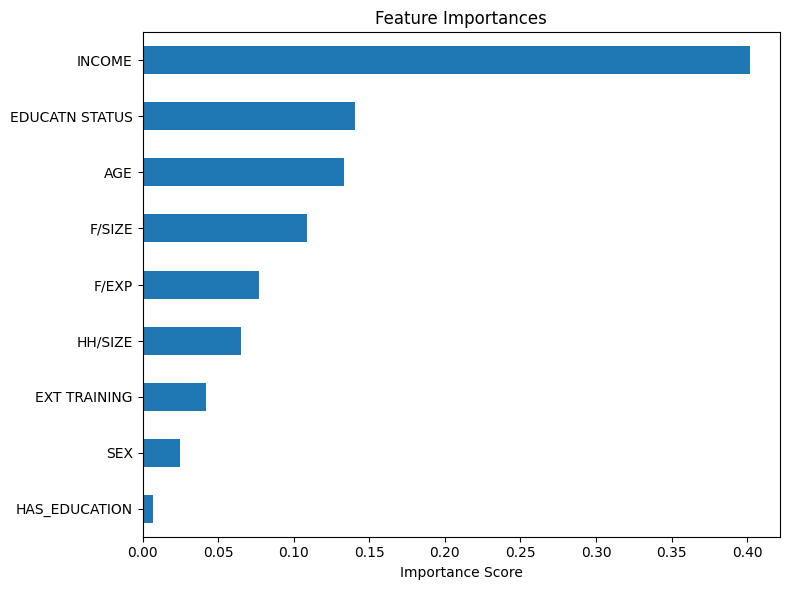

In [139]:
import matplotlib.pyplot as plt
import pandas as pd

model = best.best_estimator_.named_steps['rf']
importances = model.feature_importances_
features = x_train.columns

feat_imp = pd.Series(importances, index=features).sort_values(ascending=True)

plt.figure(figsize=(8,6))
feat_imp.plot(kind='barh')
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


In [140]:
import joblib
joblib.dump(best.best_estimator_, 'technologyadoption.pkl')


['technologyadoption.pkl']

In [141]:
!pip install catboost

In [142]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(
    verbose=0,
    random_seed=42
)

In [143]:
param_dist = {
    'iterations': [100, 300, 500],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128],
    'bootstrap_type': ['Bayesian', 'Bernoulli', 'No'],

}


In [144]:
cat_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)
cat_search.fit(x_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7bfc625e2d50>,
                   n_iter=30, n_jobs=-1,
                   param_distributions={'bootstrap_type': ['Bayesian',
                                                           'Bernoulli', 'No'],
                                        'border_count': [32, 64, 128],
                                        'depth': [4, 6, 8, 10],
                                        'iterations': [100, 300, 500],
                                        'l2_leaf_reg': [1, 3, 5, 7, 9],
                                        'learning_rate': [0.01, 0.03, 0.05,
                                                          0.1]},
                   random_state=42, scoring='accuracy', verbose=2)

In [145]:
best_cat = cat_search.best_estimator_

y_pred_cat = best_cat.predict(x_test)
print("Best Parameters:", cat_search.best_params_)

Best Parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 100, 'depth': 4, 'border_count': 64, 'bootstrap_type': 'Bayesian'}


In [146]:
from sklearn.metrics import accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred_cat))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cat))
print("Classification Report:\n", classification_report(y_test, y_pred_cat))

Accuracy: 0.7623762376237624
Confusion Matrix:
 [[41  7]
 [17 36]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.85      0.77        48
           1       0.84      0.68      0.75        53

    accuracy                           0.76       101
   macro avg       0.77      0.77      0.76       101
weighted avg       0.78      0.76      0.76       101



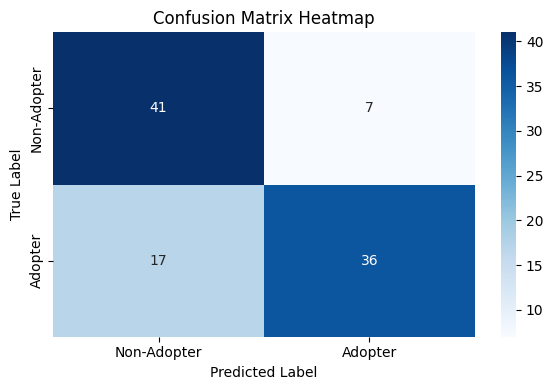

In [147]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the best estimator from the search
best_cat = cat_search.best_estimator_

# Make predictions on the test set
y_pred_cat = best_cat.predict(x_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_cat)

# Optional: define class labels
labels = ['Non-Adopter', 'Adopter']  # or ['Class 0', 'Class 1']

# Create heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

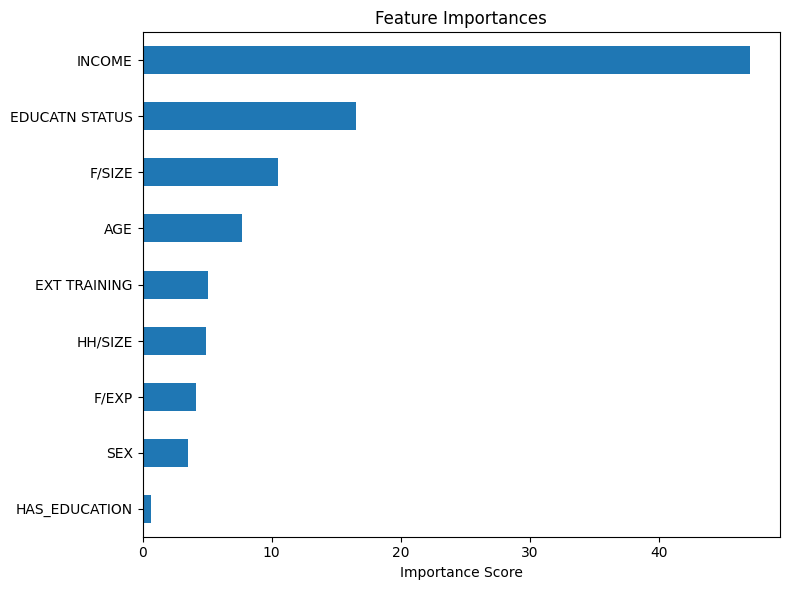

In [148]:
import matplotlib.pyplot as plt
import pandas as pd

model = cat_search.best_estimator_
importances = model.feature_importances_
features = x_train.columns

feat_imp = pd.Series(importances, index=features).sort_values(ascending=True)

plt.figure(figsize=(8,6))
feat_imp.plot(kind='barh')
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [149]:
import joblib

# Save
joblib.dump(best_cat, "catboost_model.pkl")

['catboost_model.pkl']

**Artificial Neural Network (ANN)**

In [150]:
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [151]:
import numpy as np
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [152]:
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [153]:
model.fit(x_train, y_train, epochs=50, batch_size=16, validation_split=0.2)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4576 - loss: 825.9469 - val_accuracy: 0.4625 - val_loss: 323.7629
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4414 - loss: 208.2962 - val_accuracy: 0.4625 - val_loss: 164.9545
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5459 - loss: 151.0938 - val_accuracy: 0.4625 - val_loss: 219.2188
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5387 - loss: 75.4311 - val_accuracy: 0.5375 - val_loss: 188.9850
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5448 - loss: 258.9229 - val_accuracy: 0.4625 - val_loss: 483.5537
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4634 - loss: 266.0708 - val_accuracy: 0.5375 - val_loss: 25.0821
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5053 - loss: 269.3832 - val_accuracy: 0.4625 - val_loss: 776.5234
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4753 - loss: 302.6903

In [154]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7568 - loss: 26.3693  
Test Accuracy: 0.72


In [155]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


In [158]:
from tensorflow import keras
from keras import layers
import keras_tuner as kt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

def build_model(hp):
    model = keras.Sequential()

    # Tune number of units in first dense layer
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(layers.Dense(units=hp_units, activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid'))  # For binary classification

    # Tune learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [159]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='intro_to_kt',
    seed=SEED
)


In [160]:
tuner.search(x_train, y_train,
             epochs=20,
             validation_split=0.2)


Trial 10 Complete [00h 00m 06s]
val_accuracy: 0.699999988079071

Best val_accuracy So Far: 0.699999988079071
Total elapsed time: 00h 00m 56s


In [161]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best units: {best_hps.get('units')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")


Best units: 256
Best learning rate: 0.01


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [162]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate it on the test set
test_loss, test_accuracy = best_model.evaluate(x_test, y_test)

# Print accuracy
print(f"Test Accuracy of the best model: {test_accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7874 - loss: 38.9804 
Test Accuracy of the best model: 0.7525
